In [38]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
!gdown -q 1-E-TLd5_J-DDWZXkuYL-moMpoezlMn4Z

In [26]:
!gdown -q 1gvOuxPc8dNgTnxuvPcVuCKifOf98-TV0

In [27]:
!pip install -q tqdm

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import compute_class_weight
from itertools import groupby, chain
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
from math import sqrt
import seaborn as sn
import pandas as pd
import numpy as np
import random
import pickle
import glob
import os
sn.set()


In [29]:
window_size = 200

In [30]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#Sử dụng Matplotlib và Seaborn để trực quan hóa ma trận nhầm lẫn (Confusion Matrix) dưới dạng bản đồ nhiệt (heatmap).
def plot_confusion_matrix(confusion_matrix, title='', cmap ='Greens'):
    df = pd.DataFrame(confusion_matrix, ['not fall', 'fall'], ['not fall', 'fall'])
    plt.figure(figsize=(7,4))
    if title == '' :
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix for' + ' ' + title)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 12},fmt='.0f',cmap=cmap) # font size
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

#Vẽ đồ thị Precision-Recall Curve, một công cụ hữu ích để đánh giá hiệu suất mô hình
def plot_precision_recall_curve(actual_labels, prediction, title='', model_name='', file_name=None):
    precision, recall, thresholds=precision_recall_curve(actual_labels, prediction)
    plt.figure(figsize=(8,6))
    fig, ax = plt.subplots()
    ax.plot(recall, precision, label='Model: {model_name}'.format(model_name=model_name), color='purple')

    # add axis labels to plot
    if title == '':
        plt.title(title)
    else:
        plt.title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    # display plot
    plt.show()
    if file_name is not None:
        plt.savefig(file_name)

#Vẽ đường cong ROC (Receiver Operating Characteristic Curve) – một công cụ đánh giá hiệu suất mô hình trong các bài toán phân loại nhị phân
def plot_roc_curve(actual_labels, prediction, title='', model_name='', file_name=None):
    fpr, tpr, _ = roc_curve(actual_labels, prediction)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label='Model: {model_name}'.format(model_name=model_name), color='blue')
    if title == '':
        plt.title(title)
    else:
        plt.title('ROC Learning Curves')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

    if file_name is not None:
        plt.savefig(file_name)

#Hàm này dùng để vẽ các biểu đồ đánh giá hiệu suất của mô hình trong quá trình huấn luyện, gồm:
#Loss – PRC (Precision-Recall Curve) – Precision – Recall
def plot_metrics(history):
    metrics = ['loss', 'PRC', 'Precision', 'Recall']
    plt.figure(figsize=(10,10),linewidth = 7, edgecolor="whitesmoke")

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()

#Hàm này dùng để vẽ đường cong AUC-ROC giúp đánh giá khả năng phân loại của mô hình.
def plot_auc_curve(actual_labels, prediction, title='', model_name='', file_name = None):
    fpr, tpr, _ = roc_curve(actual_labels,  prediction)
    auc = roc_auc_score(actual_labels, prediction).round(4)
    plt.figure(figsize=(8,6))
    if title == '':
        plt.title(title)
    else:
        plt.title('AUC Learning Curves')
    plt.plot(fpr,tpr, label='Model: '+ model_name + ", AUC=" + str(auc), color='red')
    plt.legend(loc=4)
    plt.show()
    if file_name is not None:
        plt.savefig(file_name)

#Vẽ biểu đồ quá trình huấn luyện gồm Accuracy & Loss.
def plot_history(history):

    plt.figure(figsize=(10,5),linewidth = 7, edgecolor="whitesmoke")
    n = len(history.history['Accuracy'])

    plt.plot(np.arange(0,n)+1,history.history['Accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n)+1,history.history['loss'],'b',marker=".")

    # offset both validation curves
    plt.plot(np.arange(0,n)+ 1,history.history['val_Accuracy'],'r')
    plt.plot(np.arange(0,n)+ 1,history.history['val_loss'],'g')

    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)

    # set vertical limit to 1
    plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show()
#Lưu biến Python vào file .pkl để dùng lại sau.

def save_pickle(variable, path):
  with open(path,'wb') as f:
    pickle.dump(variable, f)
    return
#Đọc biến từ file .pkl
def load_pickle(path):
  with open(path,'rb') as f:
    return pickle.load(f)

## Pre-Processor

In [33]:
class DatasetProcessor():

  def get_file_name(self, path, ratio=0.8):
    allfiles = []
    allFolders = sorted(glob.glob(path + "*"))
    for files in allFolders:
      allfiles.append(sorted(glob.glob(files+"/*.txt")))
    if 'desktop.ini' in allfiles:
          allfiles.remove('desktop.ini')

    dataset = np.hstack(allfiles)
    start = dataset[0].rfind('/') + 1
    end = dataset[0][start:].find('_') + start
    dataset = [list(g) for k, g in groupby(dataset, key=lambda x: x[start:end])]
    train = []
    test = []
    for data in dataset:
      if len(data) == 1:
        if random.randint(1,100)>=81:
          test.extend(data)
        else:
          train.extend(data)

      else:
        random.shuffle(data)
        train.extend(data[:int(len(data)*ratio)])
        test.extend(data[int(len(data)*ratio):])

    return train, test

  def __read_data(self, data_path):
    data = pd.read_csv(data_path, header=None)
    data.columns = ['ADXL345_x', 'ADXL345_y', 'ADXL345_z', 'ITG3200_x', 'ITG3200_y', 'ITG3200_z', 'MMA8451Q_x',
                    'MMA8451Q_y', 'MMA8451Q_z']
    data['MMA8451Q_z'] = data['MMA8451Q_z'].map(lambda x: str(x)[:-1])
    for name in data.columns :
      data[name] = data[name].astype(float)
    return data

  def __add_label(self, data_path, merge_feature=False):

    dataset = self.__read_data(data_path)

    if dataset is None or dataset.empty:  # Kiểm tra nếu dataset rỗng
        print(f"⚠️ Lỗi: Không thể đọc dữ liệu từ {data_path}")
        return None

    if not merge_feature:
      dataset['label'] = self.__get_label(data_path)
      return dataset.to_numpy()

    else:
      new_dataset = pd.DataFrame()
      new_dataset['acc_1'] = dataset.apply(
          lambda row: sqrt((row.ADXL345_x ** 2 + row.ADXL345_y ** 2 + row.ADXL345_z ** 2)), axis=1)
      new_dataset['acc_2'] = dataset.apply(
          lambda row: sqrt((row.MMA8451Q_x ** 2 + row.MMA8451Q_y ** 2 + row.MMA8451Q_z ** 2)), axis=1)
      new_dataset['geo'] = dataset.apply(
          lambda row: sqrt((row.ITG3200_x ** 2 + row.ITG3200_y ** 2 + row.ITG3200_z ** 2)), axis=1)
      new_dataset['label'] = self.__get_label(data_path)

      return np.round(new_dataset.to_numpy(), 2)

  def __get_label(self, data_path):
    label = data_path[54]
    if label =='D':
      return int(0)
    elif label =='F':
      label_path = data_path.replace('dataset', 'enhanced')
      labels = pd.read_csv(label_path, header=None)
      return labels

  def datasets_to_nparray(self, datasets_address_array, outputsize=20000000, column_dimension=10):
    result = np.zeros((outputsize, column_dimension), 'int16')
    first_index = 0
    for address in tqdm(datasets_address_array, ncols=50):
      feature = self.__add_label(address)

      result[first_index : (first_index+len(feature))] = feature
      first_index += len(feature)

    return result[result.sum(axis=1) != 0]

  def windowing2d(self, dataset, window_size=200):
    window = window_size * (dataset.shape[1]-1)
    cut = dataset.shape[0] % window_size
    feature = dataset[:-cut,0:-1]
    label = dataset[:-cut,-1]
    feature = feature.ravel().reshape(feature.size//window,window)
    label = label.reshape(label.size// window_size, window_size)
    label = label.sum(axis=1)
    label[label > 0] = 1
    feature = np.roll((np.roll(feature, -1, axis=0) - feature), 1, axis=0)
    feature[0] = 0
    return feature, label.ravel()

  def windowing3d(self, dataset, window_size=200):
    n_windows = len(dataset) // window_size
    cut = dataset.shape[0] % window_size
    feature = dataset[:-cut,0:-1]
    label = dataset[:-cut,-1]
    feature = feature.reshape(n_windows, window_size, dataset.shape[1]-1)
    label = label.reshape(n_windows, window_size, 1)
    label = label.sum(axis=1)
    label[label > 0] = 1
    feature = np.roll((np.roll(feature, -1, axis=0) - feature), 1, axis=0)
    feature[0] = 0
    return feature, label.ravel()

  def normalizer(self, scaler, X_train, X_test):
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    return X_train, X_test

  def dataset_to_tensor(self, window_size, dataset, saving_path):
    features, labels = self.windowing(self.__datasets_to_nparray(dataset), window_size)
    return features, labels

  def downsampling(self, dataset, down_sampleing_factor):
      positive = dataset[dataset['targets']==1]
      negative = dataset[dataset['targets']==0].sample(n=int(len(positive)* down_sampleing_factor))
      return pd.concat([positive, negative], ignore_index=True).sample(frac=1).reset_index(drop=True)

  def generate_class_weight(self, label):
    class_weights = compute_class_weight(class_weight = "balanced",
                                         classes = np.unique(label),
                                         y = label)
    return dict(zip(np.unique(label), class_weights))


##Xử lý dữ liệu từ SisFall dataset

In [11]:
dp = DatasetProcessor()
print(dir(dp))  # Liệt kê tất cả phương thức của đối tượng


['_DatasetProcessor__add_label', '_DatasetProcessor__get_label', '_DatasetProcessor__read_data', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'dataset_to_tensor', 'datasets_to_nparray', 'downsampling', 'generate_class_weight', 'get_file_name', 'normalizer', 'windowing2d', 'windowing3d']


In [34]:
%%time

dp = DatasetProcessor()
print('1.Split Adresses...')
train, test = dp.get_file_name('/content/gdrive/MyDrive/Datasets/SisFall_dataset/')

print('2.Extract Features and Labels...')
print('------------------------Train Dataset')
train_dataset = dp.datasets_to_nparray(train)
print('------------------------Test Dataset')
test_dataset = dp.datasets_to_nparray(test)

print('3.Windowing...')
print('------------------------Train Dataset')
X_train, y_train = dp.windowing3d(train_dataset)
print('------------------------Test Dataset')
X_test, y_test = dp.windowing3d(test_dataset)

print('4.Normalizing...')
scaler = StandardScaler()
X_train, X_test = dp.normalizer(scaler, X_train, X_test)

print('5.Calculate Class Weight...')
class_weight = dp.generate_class_weight(y_train)


1.Split Adresses...
2.Extract Features and Labels...
------------------------Train Dataset


100%|█████████| 3598/3598 [37:51<00:00,  1.58it/s]


------------------------Test Dataset


100%|███████████| 907/907 [09:58<00:00,  1.52it/s]


3.Windowing...
------------------------Train Dataset
------------------------Test Dataset
4.Normalizing...
5.Calculate Class Weight...
CPU times: user 1min 23s, sys: 9.34 s, total: 1min 32s
Wall time: 47min 57s


In [44]:
save = False
if save:
  save_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_train')
  save_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_train.pkl')
  save_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_test.pkl')
  save_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_test.pkl')

else:
  X_train = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_train.pkl')
  y_train = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_train.pkl')
  X_test = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_test.pkl')
  y_test = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_test.pkl')
  dp = DatasetProcessor()
  class_weight = dp.generate_class_weight(y_train)

In [45]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (62814, 200, 9)
y_train shape: (62814,)
X_test shape: (16472, 200, 9)
y_test shape: (16472,)


In [49]:
class Traditional_Models():

  def __init__(self,
               models,
               model_parameters,
               predictions={},
               results={}):
    self.models = models
    self.model_parameters = model_parameters
    self.predictions = predictions
    self.results = results

  def __validation(self, X_train, y_train, validation_size=0.35):
    _, X_validation, _, y_validation = train_test_split(X_train, y_train, test_size=validation_size, stratify=y_train)
    return X_validation, y_validation

  def __flatten(self, feature_3d):
    return feature_3d.reshape(feature_3d.shape[0], feature_3d.shape[1]*feature_3d.shape[-1])

  def __feature_selector(self, X_train, y_train, X_test, class_weight, d=64):
    feature_selector = DecisionTreeClassifier(class_weight=class_weight).fit(X_train, y_train)
    important_features = np.argpartition(feature_selector.feature_importances_, -d)[-d:]
    return X_train[:,important_features], X_test[:,important_features]

  def __parameter_tuning(self, model, parameters, X_validation, y_validation, scoring='f1_macro'):
    optimizer = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring)
    optimizer.fit(X_validation, y_validation)
    return model.set_params(**optimizer.best_params_)

  def __train_model(self, model, X_train, y_train):
    return model.fit(X_train, y_train)

  def __evaluate(self, model, X_test, y_test, title=''):
    prediction = model.predict(X_test)
    self.results[title] = classification_report(y_test, prediction, output_dict=True)
    print()
    plot_confusion_matrix(confusion_matrix(y_test, prediction), title=title)
    print()
    return prediction

  def pipeline(self,
               X_train,
               y_train,
               X_test,
               y_test,
               class_weight,
               validation_size=35,
               number_features=64,
               tuning_metric='f1_macro'):
    print('1) Reducing dimension of feature matrices...')
    X_train_flattened, X_test_flattened = self.__flatten(X_train), self.__flatten(X_test)
    print('2) Feature selection...')
    X_train_flattened, X_test_flattened = self.__feature_selector(X_train_flattened, y_train, X_test_flattened, class_weight=class_weight, d=number_features)
    print('3) Generating validation matrices for hyper-parameter tuning...')
    X_validation, y_validation = self.__validation(X_train_flattened, y_train, validation_size=validation_size)
    print('4) Train & Evaluation...')
    for model_name, model in self.models.items():
      print()
      print(f'----------------- Working on {model_name} -----------------')
      print()
      if model_name in self.model_parameters:
        model = self.__parameter_tuning(model, self.model_parameters[model_name], X_validation, y_validation, scoring=tuning_metric)
      mdoel =  self.__train_model(model, X_train_flattened, y_train)
      self.predictions[model_name] = self.__evaluate(model, X_test_flattened, y_test, title=model_name)
    return self.predictions, self.results

In [50]:
model_parameters = {'KNN':{'n_neighbors':[2,4,8,16], 'metric':['euclidean','cosine']},
                    'Random Forest':{'criterion':['gini', 'entropy', 'log_loss']},
                    'Decision Tree':{'criterion':['gini', 'entropy', 'log_loss']},
                    }


tradional_models = Traditional_Models(models = {'Logistic Regression':LogisticRegression(class_weight=class_weight),
                                                'Random Forest':RandomForestClassifier(class_weight=class_weight),
                                                'KNN':KNeighborsClassifier(),
                                                'Decision Tree': DecisionTreeClassifier(class_weight=class_weight)},
                                      model_parameters = model_parameters)

1) Reducing dimension of feature matrices...
2) Feature selection...
3) Generating validation matrices for hyper-parameter tuning...
4) Train & Evaluation...

----------------- Working on Logistic Regression -----------------




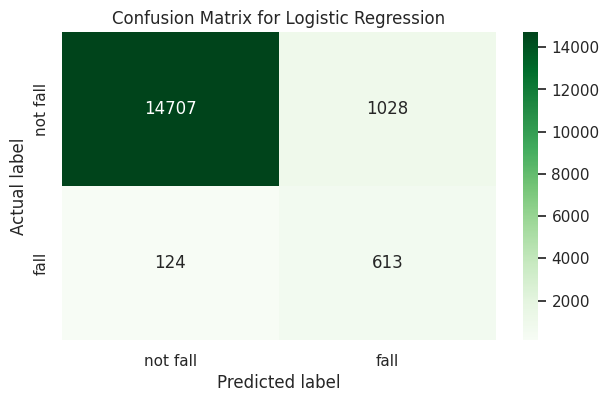



----------------- Working on Random Forest -----------------



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


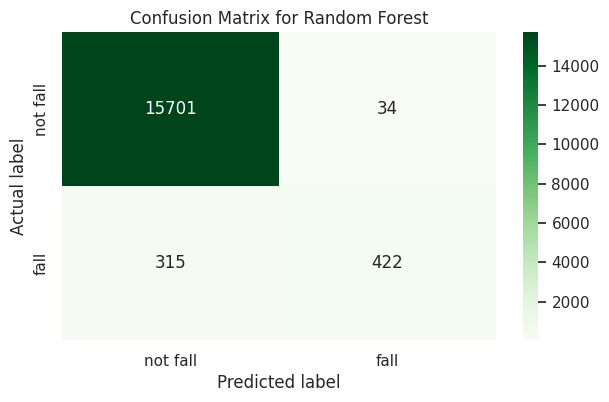



----------------- Working on KNN -----------------



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


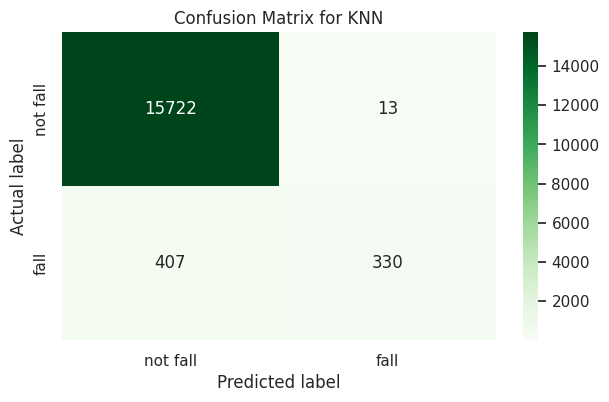



----------------- Working on Decision Tree -----------------



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


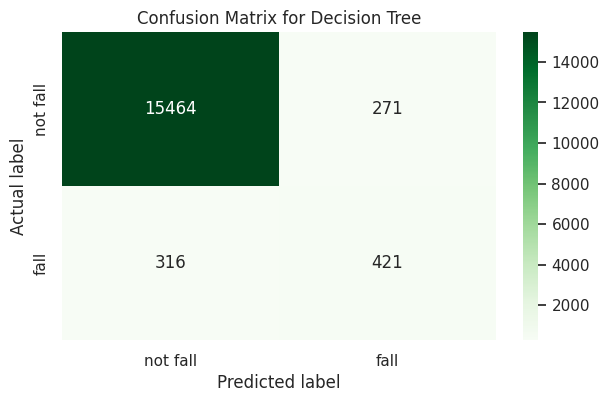

In [51]:
predictions, results = tradional_models.pipeline(X_train,
                                                 y_train,
                                                 X_test,
                                                 y_test,
                                                 class_weight)

In [53]:
save_pickle(predictions, '/content/gdrive/MyDrive/Fall Detection System/Results/predictions.pkl')
save_pickle(results, '/content/gdrive/MyDrive/Fall Detection System/Results/results.pkl')

In [54]:
classification_metrics = [keras.metrics.TruePositives(name='TP'),
                          keras.metrics.FalsePositives(name='FP'),
                          keras.metrics.TrueNegatives(name='TN'),
                          keras.metrics.FalseNegatives(name='FN'),
                          keras.metrics.BinaryAccuracy(name='Accuracy'),
                          keras.metrics.Precision(name='Precision'),
                          keras.metrics.Recall(name='Recall'),
                          keras.metrics.AUC(name='AUC'),
                          keras.metrics.AUC(name='PRC', curve='PR')]

def get_early_stopping(metric='val_PRC', patience=5, mode='max'):
  early_stopping = keras.callbacks.EarlyStopping(monitor=metric,
                                                verbose=1,
                                                patience=patience,
                                                mode=mode,
                                                restore_best_weights=True)
  return early_stopping

In [55]:
class Train_Evaluate_Deep():

  def __init__(self,
               predictions={},
               results={}):

      self.predictions = predictions
      self.results = results

  def build_cnn(self, input_size, units=128, drop_rate=0.25, filter=32, kernel_size=(1*9), output_size=1):
    input = keras.layers.Input((input_size))
    x = keras.layers.Conv1D(filters=filter//2, kernel_size=kernel_size, padding='same', activation='relu', name="conv1")(input)
    x = keras.layers.Conv1D(filters=filter, kernel_size=kernel_size, padding='same', activation='relu', name="conv2")(x)
    x = keras.layers.Conv1D(filters=filter*2, kernel_size=kernel_size, padding='same', activation='relu', name="conv3")(x)
    x = tf.keras.layers.Flatten()(x)
    classifier = keras.layers.Dense(units*4, activation='relu')(x)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units//2, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    output = keras.layers.Dense(output_size, activation='sigmoid')(classifier)
    model = keras.Model(inputs=input, outputs=output)
    return model

  def build_lstm(self, input_size, units=128, drop_rate=0.25, lstm_units=16, output_size=1):
    input = keras.layers.Input((input_size))
    x = keras.layers.LSTM(units=lstm_units//2, input_shape=input_size, return_sequences=True, name="lstm1")(input)
    x = keras.layers.LSTM(units=lstm_units, input_shape=input_size, return_sequences=True, name="lstm2")(x)
    x = keras.layers.LSTM(units=lstm_units*2, input_shape=input_size, return_sequences=True, name="lstm3")(x)
    x = tf.keras.layers.Flatten()(x)
    classifier = keras.layers.Dense(units*4, activation='relu')(x)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units//2, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    output = keras.layers.Dense(output_size, activation='sigmoid')(classifier)
    model = keras.Model(inputs=input, outputs=output)
    return model

  def build_mlp(self, input_size, hidden_layer_size=128, output_size=1, drop_rate=0.25):
    input = keras.layers.Input((input_size))
    x = keras.layers.Dense(hidden_layer_size//4, activation='relu')(input)
    x = keras.layers.Dense(hidden_layer_size//2, activation='relu')(x)
    x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    classifier = keras.layers.Dense(hidden_layer_size*4, activation='relu')(x)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(hidden_layer_size, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(hidden_layer_size//2, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    output = keras.layers.Dense(output_size, activation='sigmoid')(classifier)
    model = keras.Model(inputs=input, outputs=output)
    return model

  def build_AE(self, input_size, latent_dim=128, filter=64, kernel_size=(1*9)):
    input = keras.layers.Input((input_size))
    encoder = keras.layers.Conv1D(filters=filter//2, kernel_size=kernel_size, padding='same', activation='relu', name="conv1")(input)
    encoder = keras.layers.Conv1D(filters=filter, kernel_size=kernel_size, padding='same', activation='relu', name="conv2")(encoder)
    encoder = tf.keras.layers.Flatten()(encoder)
    encoder = keras.layers.Dense(latent_dim*4, activation='relu')(encoder)
    encoder = keras.layers.Dense(latent_dim*2, activation='relu')(encoder)

    latent = keras.layers.Dense(latent_dim, activation='relu')(encoder)

    decoder = keras.layers.Dense(latent_dim*2, activation='relu')(latent)
    decoder = keras.layers.Dense(latent_dim*4, activation='relu')(decoder)
    decoder = keras.layers.Dense(filter*input_size[0], activation='relu')(decoder)
    decoder = keras.layers.Reshape((input_size[0], filter))(decoder)
    decoder = keras.layers.Conv1DTranspose(filters=filter, kernel_size=kernel_size, padding='same', activation='relu')(decoder)
    decoder = keras.layers.Conv1DTranspose(filters=filter//2, kernel_size=kernel_size, padding='same', activation='relu')(decoder)

    output = keras.layers.Conv1DTranspose(filters=input_size[-1], kernel_size=kernel_size, padding='same', activation='relu')(decoder)
    model = keras.Model(inputs=input, outputs=output)
    return model

  def train_deep_model(self,
                       model,
                       X_train,
                       y_train,
                       metrics,
                       loss_function,
                       optimizer,
                       callbacks,
                       class_weight=None,
                       epochs=100,
                       batch_size=128,
                       validation_split=0.2):

    print('----------------------------------')
    print(model.summary())
    print('----------------------------------')

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    if not class_weight is None:
      history = model.fit(X_train,
                          y_train,
                          batch_size = batch_size,
                          epochs = epochs,
                          shuffle = True,
                          class_weight = class_weight,
                          validation_split = validation_split,
                          callbacks = callbacks,
                          verbose = 1)
    else:
      history = model.fit(X_train,
                          y_train,
                          batch_size = batch_size,
                          epochs = epochs,
                          shuffle = True,
                          validation_split = validation_split,
                          callbacks = callbacks,
                          verbose = 1)
    return history

  def evaluate(self, model, X_test, y_test, batch_size=128, threshold=0.5, title='', model_name='', plot=True):
    prediction = model.predict(X_test, batch_size=batch_size)
    self.predictions[model_name] = prediction
    prediction = np.where(prediction >= threshold, 1, 0)
    if plot:
      print()
      print('1) Plot ROC Curve...')
      print()
      plot_roc_curve(y_test, prediction, title='ROC Curve of {model_name} Model'.format(model_name=model_name), model_name=model_name, file_name=None)
      print()
      print('2) Plot AUC Curve...')
      print()
      plot_auc_curve(y_test, prediction, title='AUC Curve of {model_name} Model'.format(model_name=model_name), model_name=model_name, file_name = None)
      print()
      print('3) Plot Percision_Recall Curve......')
      print()
      plot_precision_recall_curve(y_test, prediction, title='Percision_Recall Curve of {model_name} Model'.format(model_name=model_name), model_name=model_name, file_name=None)
    report = classification_report(y_test, prediction, output_dict=True)
    self.results[model_name] = report
    print()
    plot_confusion_matrix(confusion_matrix(y_test, prediction), title=title)
    print()
    return prediction

  def plot_learning_curves(self, history):
    print('1) Plot learning process based on different metrics...')
    print()
    plot_metrics(history)
    print()
    print('2) Plot learning curve...')
    print()
    return plot_history(history)

In [56]:
predictions = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Results/predictions.pkl')
results = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Results/results.pkl')

train_evaluate_deep = Train_Evaluate_Deep(predictions=predictions,
                                          results=results)

1. Build Model...
2. Train Model...
----------------------------------


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 200, 16)             │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 200, 32)             │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv1D)                       │ (None, 200, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,652,545 (25.38 MB)

 Trainable params: 6,652,545 (25.38 MB)

 Non-trainable params: 0 (0.00 B)

None
----------------------------------
Epoch 1/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 147s 363ms/step - AUC: 0.8643 - Accuracy: 0.2453 - FN: 21.1726 - FP: 17917.4375 - PRC: 0.3200 - Precision: 0.0678 - Recall: 0.9715 - TN: 5976.4668 - TP: 1364.3300 - loss: 0.6262 - val_AUC: 0.9129 - val_Accuracy: 0.3779 - val_FN: 0.0000e+00 - val_FP: 7815.0000 - val_PRC: 0.1720 - val_Precision: 0.0164 - val_Recall: 1.0000 - val_TN: 4618.0000 - val_TP: 130.0000 - val_loss: 0.8876
Epoch 2/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 199s 355ms/step - AUC: 0.9426 - Accuracy: 0.5456 - FN: 17.4569 - FP: 11009.4775 - PRC: 0.5853 - Precision: 0.1113 - Recall: 0.9888 - TN: 12849.1221 - TP: 1403.3502 - loss: 0.5259 - val_AUC: 0.9240 - val_Accuracy: 0.6466 - val_FN: 8.0000 - val_FP: 4432.0000 - val_PRC: 0.3428 - val_Precision: 0.0268 - val_Recall: 0.9385 - val_TN: 8001.0000 - val_TP: 122.0000 - val_loss: 0.7288
Epoch 3/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 134s 340ms/step - AUC: 0.9568 - Accuracy: 0.7708 - FN: 56.9924 - FP: 5423.2769 - 

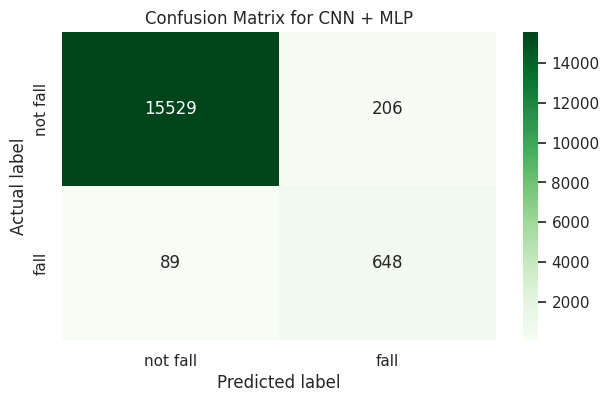

In [57]:
print('1. Build Model...')
cnn_model = train_evaluate_deep.build_cnn(input_size=X_train.shape[1:])
print('2. Train Model...')
cnn_history = train_evaluate_deep.train_deep_model(cnn_model,
                                                   X_train,
                                                   y_train,
                                                   optimizer=tf.optimizers.SGD(learning_rate=0.001),
                                                   loss_function=keras.losses.BinaryCrossentropy(),
                                                   callbacks=[get_early_stopping(metric='val_PRC', patience=10, mode='max')],
                                                   metrics=classification_metrics,
                                                   class_weight=class_weight,
                                                   epochs=30)
print('3. Evaluation...')
prediction = train_evaluate_deep.evaluate(cnn_model, X_test, y_test, batch_size=128, threshold=0.9, title='CNN + MLP', model_name='CNN + MLP', plot=False)

plot_learning_curves=False
if plot_learning_curves:
  print('4. Plot learning curves...')
  _ = train_evaluate_deep.plot_learning_curves(cnn_history)

In [58]:
predictions = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Results/predictions.pkl')
results = load_pickle('/content/gdrive/MyDrive/Fall Detection System/Results/results.pkl')

In [59]:
import pandas as pd

def convert_report_df(report):
  d = {}
  for key, value in report.items():
      temp = {}
      for label, metrics in value.items():
        if type(metrics)==dict:
          for metric, score in metrics.items():
            temp[metric+'_'+label] = score
        else:
          temp[label] = metrics
      d[key] = temp
  return pd.DataFrame.from_dict(d).T.style.background_gradient(cmap="PuBu")

convert_report_df(results)


,precision_0,recall_0,f1-score_0,support_0,precision_1,recall_1,f1-score_1,support_1,accuracy,precision_macro avg,recall_macro avg,f1-score_macro avg,support_macro avg,precision_weighted avg,recall_weighted avg,f1-score_weighted avg,support_weighted avg
Logistic Regression,0.991639,0.934668,0.962311,15735.000000,0.373553,0.831750,0.515559,737.000000,0.930063,0.682596,0.883209,0.738935,16472.000000,0.963984,0.930063,0.942322,16472.000000
Random Forest,0.980332,0.997839,0.989008,15735.000000,0.925439,0.572592,0.707460,737.000000,0.978813,0.952885,0.785215,0.848234,16472.000000,0.977876,0.978813,0.976411,16472.000000
KNN,0.974766,0.999174,0.986819,15735.000000,0.962099,0.447761,0.611111,737.000000,0.974502,0.968433,0.723468,0.798965,16472.000000,0.974199,0.974502,0.970009,16472.000000
Decision Tree,0.979975,0.982777,0.981374,15735.000000,0.608382,0.571235,0.589223,737.000000,0.964364,0.794178,0.777006,0.785299,16472.000000,0.963349,0.964364,0.963828,16472.000000
